# Neural Network - Optimizers
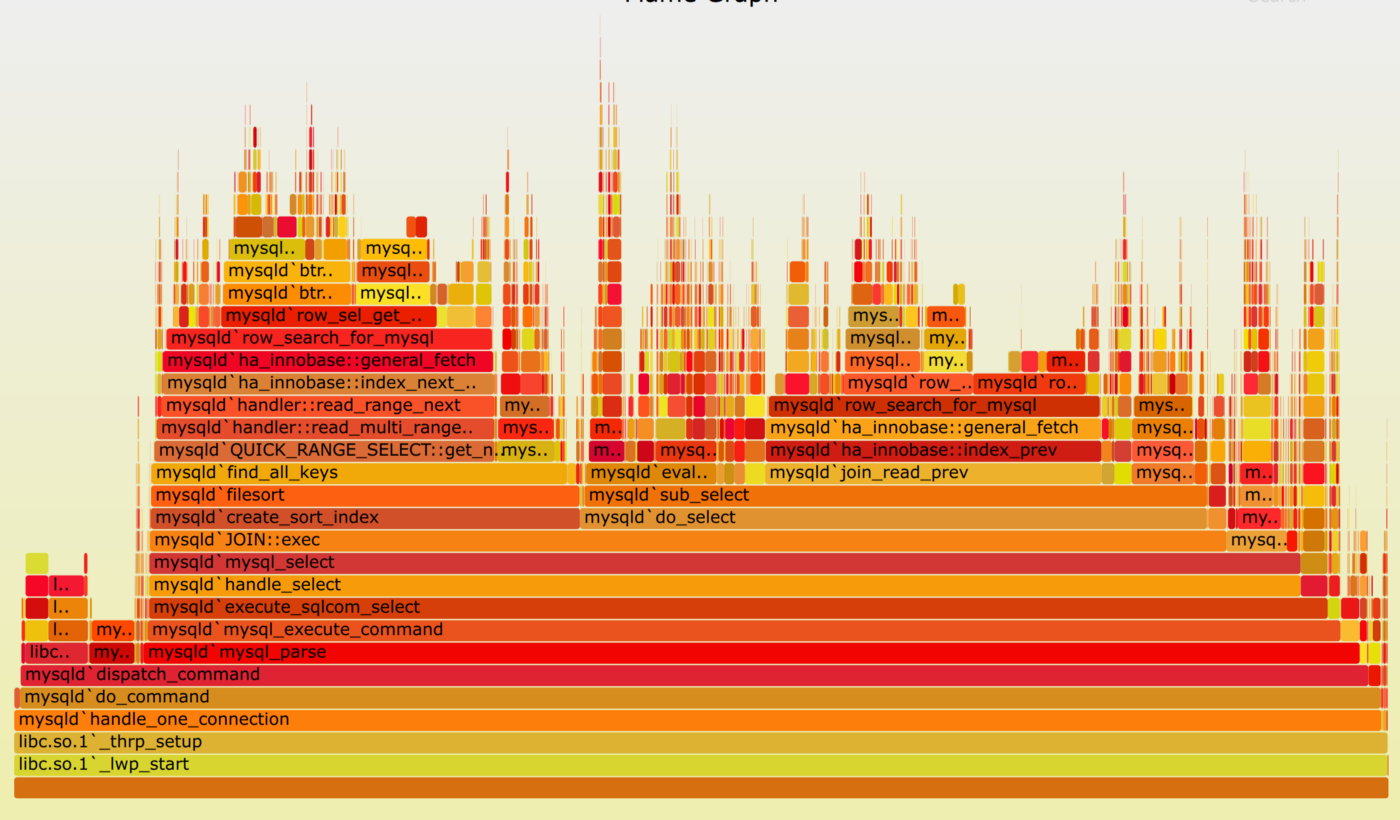

# Setup

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
import keras

from keras import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Softmax

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop

from keras.utils import to_categorical
from keras.initializers import RandomNormal

from IPython.display import Image
from colour import Color

In [2]:
# Ignore TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')

tf.logging.set_verbosity(tf.logging.ERROR)

In [49]:
#pip install colour

Note: you may need to restart the kernel to use updated packages.


# Data

In [3]:
fashion = keras.datasets.fashion_mnist.load_data()

In [4]:
(X_train, y_train), (X_test, y_test) = fashion

In [5]:
print(f'Training Images {X_train.shape}, Labels {y_train.shape}')
print(f'Testing  Images {X_test.shape}, Labels {y_test.shape}')

Training Images (60000, 28, 28), Labels (60000,)
Testing  Images (10000, 28, 28), Labels (10000,)


## Examples

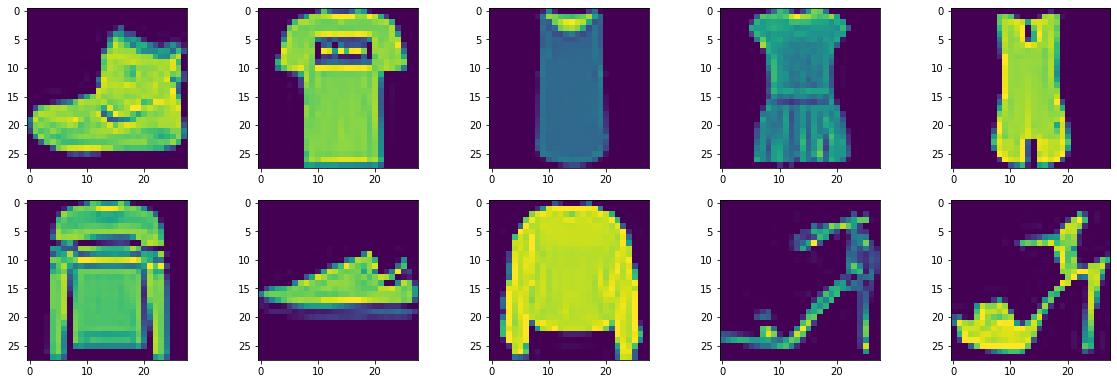

In [6]:
plt.figure(figsize=(20,10))
cols = 5
for i, image in enumerate(X_train[0:10, :]):
    plt.subplot(10 / cols + 1, cols, i + 1)
    plt.imshow(image.squeeze())

## Images

In [7]:
X_train = X_train.reshape(60000, 784).astype('float32')
X_test  = X_test.reshape(10000, 784).astype('float32')

In [8]:
X_train /= 255
X_test  /= 255

## Labels

In [9]:
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

# Helpers

In [10]:
def plot_performance(history, color='b'):
    fig, ax = plt.subplots(figsize=(12,8))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Parameters

In [11]:
batch_size = 64
epochs     = 50
neurons    = 64
activation = 'relu'

# Model
* Using Relu
* Using default Xavier / Glorot initialization

In [12]:
def create_model():
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(784, )))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(10, activation='softmax'))
    return model

In [13]:
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


# Tracking

In [14]:
resultsDF = pd.DataFrame(columns=['Loss', 'Accuracy'])

# SGD
* Stochastic Gradient Descent
* Heavily influence by learning rate
    * Grid / Random Search
    * Watching Learning Rate Curves & Adjusting
* Affected by Batch Size
    * Small batches act as a regularizer (they introduce noise)
    * Large batch size gives more precise estimate of the gradient
    * Typically set as large as your GPU will accommodate

## Algorithm

In [15]:
Image(url='https://blog.paperspace.com/content/images/2018/05/grad_eq-4.png')

## Model

In [16]:
sgd = SGD(lr=0.001)
model = create_model()
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history_sgd = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)

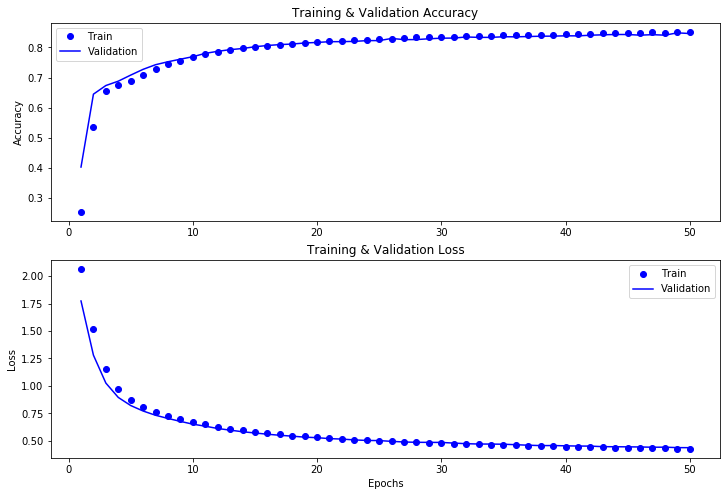

In [18]:
plot_performance(history_sgd)

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
resultsDF.loc['SGD']= [loss, accuracy]
print(f'Test Loss {loss}, Accuracy {accuracy}')

10000/10000 [==============================] - 0s 13us/step
Test Loss 0.4695257143974304, Accuracy 0.8372


# Momentum
* SGD uses the current step to search
* This can lead to slow learning as we slowly take steps
* Improving SGD
    * SGD is analagous to finding your way down a surface
    * You tap your foot around in multiple directions to find the gradient and take a small step
    * You know it'll get you to the minimum
    * But you look up from your feet, look around and see ...

In [20]:
Image(url='https://gamepedia.cursecdn.com/minecraft_gamepedia/thumb/d/d9/Flatland.png/600px-Flatland.png?version=c5ace9663da4319d9a146c2b9babc847')

## Algorithm
* It accumulates the gradient of past steps in addition to the gradient of the current step
* The coefficient of momentum is used to control how much we listen to prior gradients
* Learning rate sets how much we listen to the gradient of the current step

In [21]:
Image(url='https://blog.paperspace.com/content/images/2018/06/momentum2-1.png')

## Hyperparameter Search

In [22]:
momentum_trials = np.arange(0, 1.0, 0.1)
print(momentum_trials)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [23]:
histories = {}
for mom in momentum_trials:
    print(f'Running Model with {mom:.1f} for Momentum')
    momentum = SGD(lr=0.001, momentum=mom)
    model = create_model()
    model.compile(optimizer=momentum, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)
    histories[mom] = history

Running Model with 0.0 for Momentum
Running Model with 0.1 for Momentum
Running Model with 0.2 for Momentum
Running Model with 0.3 for Momentum
Running Model with 0.4 for Momentum
Running Model with 0.5 for Momentum
Running Model with 0.6 for Momentum
Running Model with 0.7 for Momentum
Running Model with 0.8 for Momentum
Running Model with 0.9 for Momentum


## Comparison

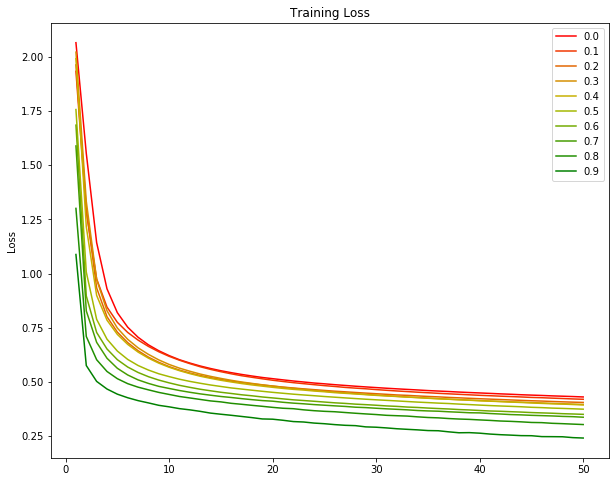

In [57]:
plt.figure(figsize=(10,8))
colors = (Color('red').range_to(Color('green'), 10))
for key, history in histories.items():
    val_acc = history.history['loss']
    epochs_range = range(1, len(val_acc) + 1) 
    color = next(colors)
    plt.plot(epochs_range, val_acc, 'b', color=str(color), label=f'{key:.1f}')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.legend();

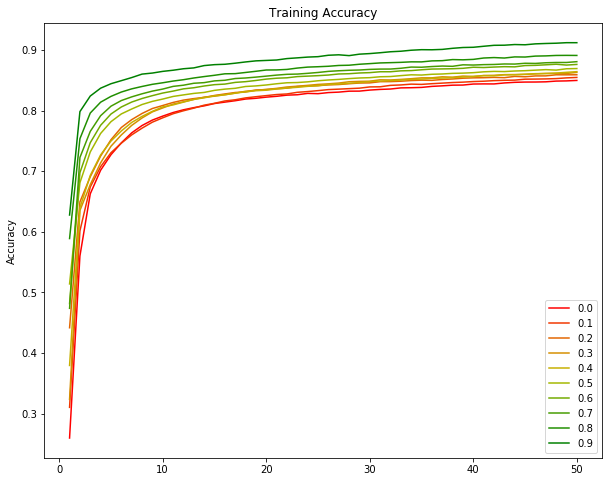

In [59]:
plt.figure(figsize=(10,8))
colors = (Color('red').range_to(Color('green'), 10))
for key, history in histories.items():
    val_acc = history.history['acc']
    epochs_range = range(1, len(val_acc) + 1) 
    color = next(colors)
    plt.plot(epochs_range, val_acc, 'b', color=str(color), label=f'{key:.1f}')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.legend();

## Model

In [26]:
momentum = SGD(lr=0.001, momentum=0.9)
model = create_model()
model.compile(optimizer=momentum, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history_momentum = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)

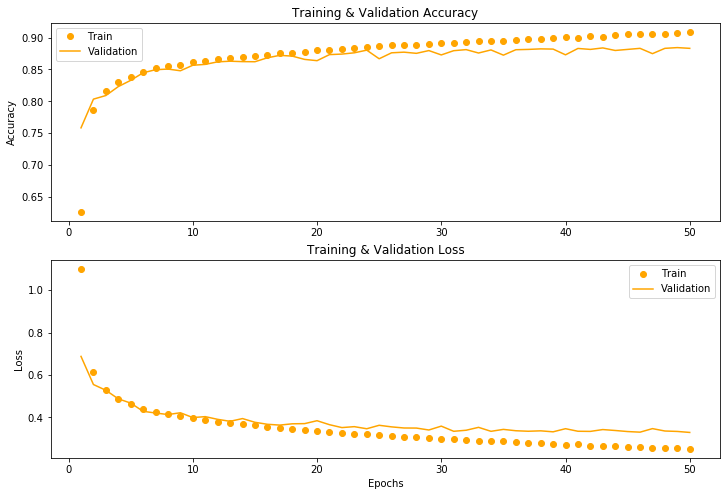

In [28]:
plot_performance(history_momentum, color='orange')

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
resultsDF.loc['Momentum']= [loss, accuracy]
print(f'Test Loss {loss}, Accuracy {accuracy}')

10000/10000 [==============================] - 0s 16us/step
Test Loss 0.35203396411538124, Accuracy 0.8759


# Nesterov Momentum
* Our gradient will always point in the correct direction to move
* Our momentum may not, and we can overshoot or be moving in the wrong direction
* Nesterov makes a change to the momentum computation
* It computes the gradient from an estimated position, rather than the current position
* Nesterov is trying to add a correction factor to standard momentum

In [30]:
Image(url='http://www.sondrakistan.com/wp-content/uploads/2015/03/wile-e-coyote-cliff-300x264.gif')

In [31]:
Image(url='https://golden-storage-production.s3.amazonaws.com/topic_images/7a00dcd221e745708101d89f4c4c2a5c.png')

## Model

In [32]:
nesterov = SGD(lr=0.001, momentum=0.9, nesterov=True)
model = create_model()
model.compile(optimizer=nesterov, loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history_nesterov = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)

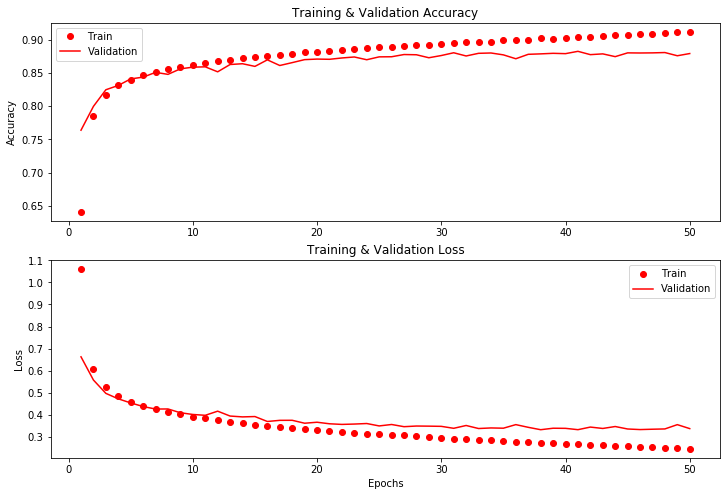

In [34]:
plot_performance(history_nesterov, color='red')

In [35]:
loss, accuracy = model.evaluate(X_test, y_test)
resultsDF.loc['Nesterov']= [loss, accuracy]
print(f'Test Loss {loss}, Accuracy {accuracy}')

10000/10000 [==============================] - 0s 17us/step
Test Loss 0.3625446009874344, Accuracy 0.8703


# RMSProp
* Think golf!
    * Start by driving the ball - big steps (high learning rate)
    * Finish by putting the ball - small steps (small learning rate) 
* Developed by Hinton (Backprogation)
    * Not published but shown in slides for a Neural Network class
    * Uses a learning rate per parameter in the model
    * Divides the learning rate for a parameter by the running avg of the magnitudes of recent gradients of the weight
* Uses two hyperparamters
    * Learning rate (Typically set to 0.001)
    * Decay Rate - Similar to the moving momentum term (Typically set to 0.95)
* The key insights are:
    * Multiple learning rates
    * Learning rates get smaller over time
    * Moving average helps with vanishing & exploding gradients
* Other closely related methods include (AdaGrad & AdaDelta)

In [36]:
Image(url='https://i.gifer.com/7425.gif')

In [37]:
rms = RMSprop(lr=0.001)
model = create_model()
model.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
history_rms = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)

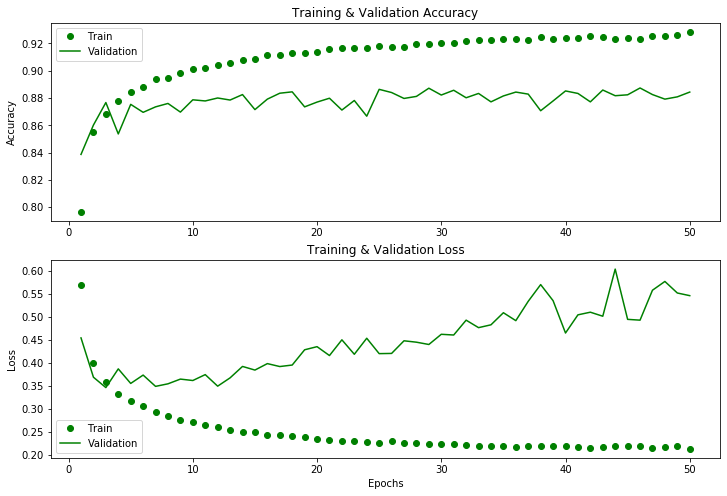

In [39]:
plot_performance(history_rms, color='green')

In [40]:
loss, accuracy = model.evaluate(X_test, y_test)
resultsDF.loc['RMSprop']= [loss, accuracy]
print(f'Test Loss {loss}, Accuracy {accuracy}')

10000/10000 [==============================] - 0s 17us/step
Test Loss 0.5762044924616814, Accuracy 0.8779


# Adam
* Ada(ptive) m(oments)
* Combination of Momentum and RMSprop
* Frequently used and performs well
* Think RMSprop (Weight per parameter, Decay Rate & Learning Rate)
    * With an extra moving average param of past gradients
    * And a bias trick to prevent moving averages from skewing to zero
* Typical hyperparameter settings:
    * Learning rate = 0.001
    * RMSprop decay rate = 0.9
    * Moving average gradient rate = 0.999
* RMSprop, AdaDelta & Adam are often interchangeable
* Although Adam is used heavily, SGD with Momentum (or Nesterov) can work well

In [41]:
adam = Adam(lr=0.001)
model = create_model()
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
history_adam = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0)

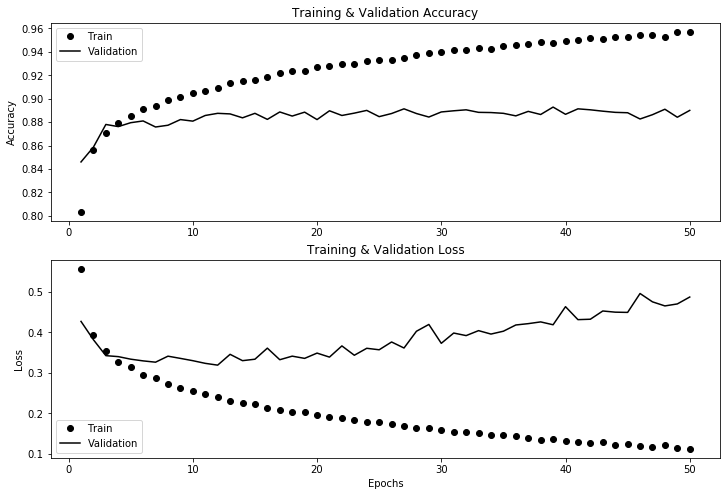

In [43]:
plot_performance(history_adam, color='black')

In [44]:
loss, accuracy = model.evaluate(X_test, y_test)
resultsDF.loc['Adam']= [loss, accuracy]
print(f'Test Loss {loss}, Accuracy {accuracy}')

10000/10000 [==============================] - 0s 17us/step
Test Loss 0.503493809747696, Accuracy 0.8842


# Comparison

## Test Accuracy

In [45]:
resultsDF

,Loss,Accuracy
SGD,0.469526,0.8372
Momentum,0.352034,0.8759
Nesterov,0.362545,0.8703
RMSprop,0.576204,0.8779
Adam,0.503494,0.8842


## Loss

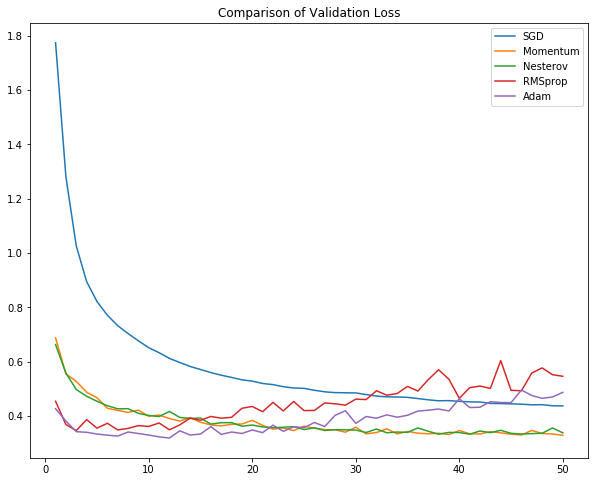

In [46]:
ranged  = range(1, epochs + 1)
plt.figure(figsize=(10,8))
plt.plot(ranged, history_sgd.history['val_loss'],      label='SGD')
plt.plot(ranged, history_momentum.history['val_loss'], label='Momentum')
plt.plot(ranged, history_nesterov.history['val_loss'], label='Nesterov')
plt.plot(ranged, history_rms.history['val_loss'],      label='RMSprop')
plt.plot(ranged, history_adam.history['val_loss'],     label='Adam')
plt.title('Comparison of Validation Loss')
plt.legend()
plt.show()

## Accuracy Comparison

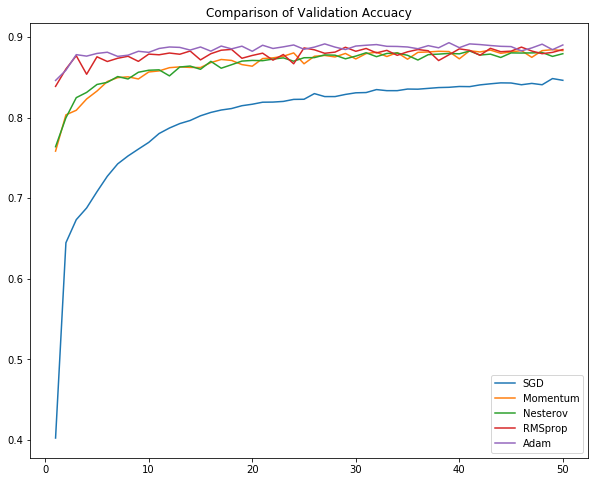

In [47]:
ranged  = range(1, epochs + 1)
plt.figure(figsize=(10,8))
plt.plot(ranged, history_sgd.history['val_acc'],      label='SGD')
plt.plot(ranged, history_momentum.history['val_acc'], label='Momentum')
plt.plot(ranged, history_nesterov.history['val_acc'], label='Nesterov')
plt.plot(ranged, history_rms.history['val_acc'],      label='RMSprop')
plt.plot(ranged, history_adam.history['val_acc'],     label='Adam')
plt.title('Comparison of Validation Accuacy')
plt.legend()
plt.show()

# Closing
* With these items fixed:
    * Fashion Dataset
    * Feed Forward Network (Not a CNN)
    * Learning rate 
* SGD learns slowly 
* SGD + Momentum (Nesterov) learns faster 
* RMSprop & Adam perform well learning fastest
* The choice of optimizer leads to more hyper parameters
    * Learning rate (Perhaps the most important)
    * Momentum (and others exposed by the optimizer)
    * Weight decay (L2 regularization)
    * Batch Size
* Which one?
    * Seems to depend on user familiarity with algorithm
    * Driven by how to tune hyperparameters

In [48]:
Image(url='https://i.imgur.com/NKsFHJb.gif?1')